# Tests on dynamo region

- Useful imports 

In [1]:
import os
import scipy.io as sio
from scipy.io import readsav
from scipy.optimize import curve_fit
import numpy as np
from math import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib widget

from star import Star
from planet import Planet
from dynamo_region import DynamoRegion
from target_selection import Config


- Useful constants :

In [2]:
MS = 1.989e30  # kg
RS = 6.96342e8  # m
AS = 4.6  # yo
BSsw = 1  # T
LS = 3.826e26  # W

MJ = 1.8986e27  # kg
RJ = 69911e3  # m
wJ = 1.77e-4  # s-1
LJ_norm=1.31e-9
dJ=5.2*149597870700

- Configuration :

In [3]:
config_param = Config()
data =pd.read_csv(r'exoplanet.eu_catalog.csv')
data = config_param.param_names(data=data)

- Instanciating Jupiter and the Sun :

In [4]:
jup = Planet(
    name="Jupiter",
    mass=1.0,
    radius={"models": config_param.planet_radius_models, "radius": 1.0},
    distance=5.2,
    worb={"star_mass": MS, "worb": 1.0},
    luminosity={
        "models": config_param.planet_luminosity_models,
        "luminosity": np.nan,
        "star_age": 4.6,
    },
    wrot=1.0,
)

sun = Star(
    name="Soleil",
    mass=1.0,
    radius={"models": config_param.star_radius_models, "radius": 1.0},
    age=AS,
    obs_dist=1.0,
    sp_type='V'
)
print(sun.luminosity)

0.6977165691451518


We test the computing of the parameters of the dynamo region and the magnetic moment derived. We test the validity of the differents models and assumptions used.

Tests with a short list of planets in order to compare with the results in JMG thesis.

In [5]:
test_targets=pd.DataFrame({'star_radius' : [1.0,1.0,1.18,1.12,1.48,1.48,1.48], 
                'star_mass':[1.0,1.0,1.06,1.1,1.42,1.42,1.42],
                'star_age' : [4.6,4.6,5.5,3.0,1.0,1.0,1.0], 
                'planet_radius':[1.0,0.84,1.42,1.25,1.2,1.58,1.48], 
                'planet_mass':[1.0,0.3, 0.69,1.18,4.4,7.0,10.0], 
                'planet_orbital_frequency':[1.0,0.93,0.12,0.34,0.12,0.12,0.12], 
                'planet_distance':[5.2,9.5,0.045,0.0225,0.0489,0.0489,0.0489]}, 
                index=['Jupiter','Saturn','HD 209458b','OGLE-TR-56b','T-bootes (light)','T-bootes (medium)','T-bootes (heavy)'])
#print(test_targets)
#print(test_targets.loc['Jupiter'])

rc1=[]
rc2=[]
rhoc1=[]
rhoc2=[]

rc1_norm=[]
rc2_norm=[]

for x in test_targets.itertuples():
    pla = Planet(
            name=x.Index,
            mass=x.planet_mass,
            radius={"models": config_param.planet_radius_models, "radius": x.planet_radius},
            distance=x.planet_distance,
            worb={"star_mass": x.star_mass, "worb": x.planet_orbital_frequency},
            luminosity={
                "models": config_param.planet_luminosity_models,
                "luminosity": np.nan,
                "star_age": x.star_age,
            },
            detection_method='bla',
            wrot=1.0,
        )

    r1=DynamoRegion._LaneEmden(pla.unnormalize_mass(), pla.unnormalize_radius(),1000)
    r2=DynamoRegion._LaneEmden(pla.unnormalize_mass(), pla.unnormalize_radius(),700)
    rc1.append(r1)
    rc2.append(r2)
    rc1_norm.append(r1/pla.unnormalize_radius())
    rc2_norm.append(r2/pla.unnormalize_radius())

    rho1=DynamoRegion._rhodyn(pla.unnormalize_mass(),pla.unnormalize_radius(),r1)
    rho2=DynamoRegion._rhodyn(pla.unnormalize_mass(),pla.unnormalize_radius(),r2)
    rhoc1.append(rho1)
    rhoc2.append(rho2)

rc1_normJ=np.array(rc1)/rc1[0]
rc2_normJ=np.array(rc2)/rc2[0]
rhoc1_norm=np.array(rhoc1)/rhoc1[0]
rhoc2_norm=np.array(rhoc2)/rhoc2[0]

test_results_dynamo=pd.DataFrame({'rc1':rc1_norm, 'rc2':rc2_norm, 'rhoc1':rhoc1_norm, 'rhoc2':rhoc2_norm}, index=['Jupiter','Saturn','HD 209458b','OGLE-TR-56b','T-bootes (light)','T-bootes (medium)','T-bootes (heavy)'] )


print(test_results_dynamo)


                        rc1       rc2     rhoc1     rhoc2
Jupiter            0.791454  0.848782  1.000000  1.000000
Saturn             0.615022  0.721287  0.676447  0.647143
HD 209458b         0.000000  0.438998  0.000000  0.442728
OGLE-TR-56b        0.672431  0.762088  0.742792  0.718751
T-bootes (light)   0.911164  0.936492  1.957362  2.065509
T-bootes (medium)  0.875936  0.910804  1.483899  1.536665
T-bootes (heavy)   0.925786  0.947091  2.285726  2.433248


Calculations and plots of rho, rho' and Rc for a given planet.

0.47696287001634724
0.43531507731149816


/Users/emauduit/Documents/GitHub/PALANTIR/dynamo_region.py:122: RuntimeWarning: invalid value encountered in double_scalars
  res = a * np.sin(b) / b
/Users/emauduit/Documents/GitHub/PALANTIR/dynamo_region.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  (np.cos(np.pi * r / Rp) / r)
/Users/emauduit/Documents/GitHub/PALANTIR/dynamo_region.py:130: RuntimeWarning: invalid value encountered in double_scalars
  - (np.sin(np.pi * r / Rp) * Rp / (np.pi * pow(r, 2)))


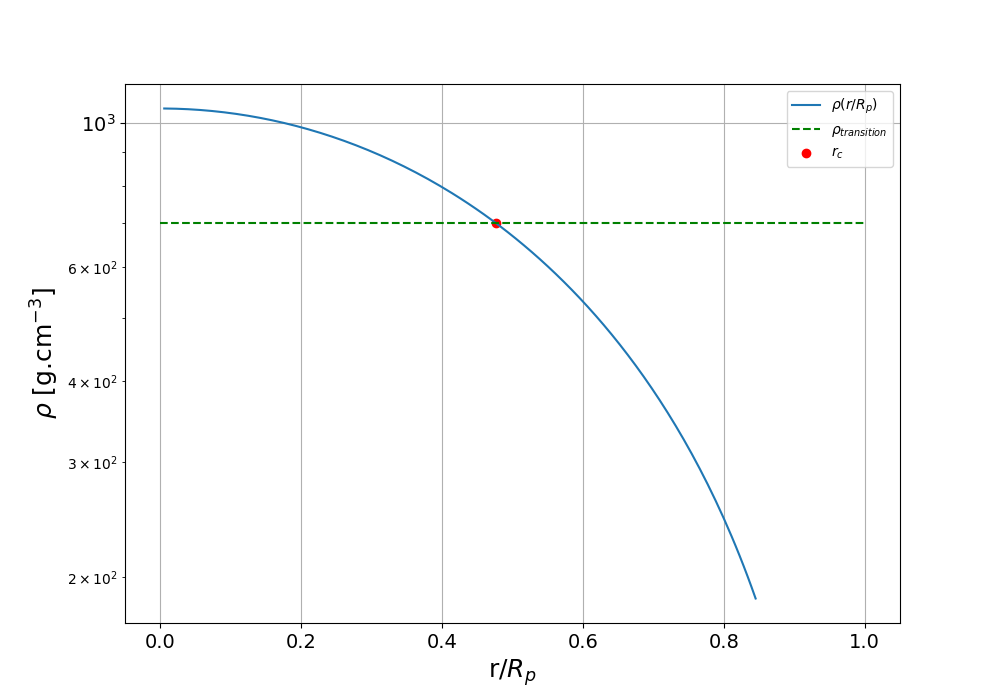

In [6]:
MJ = 1.8986e27  # kg
RJ = 69911e3  # m
R=np.linspace(0.0,1.2,150)*RJ#jup.radius
Mp=0.69*MJ#jup.mass
Rp=1.42*RJ#jup.radius
rho=[]
rhop=[]
rhott=700

a=-np.pi*Mp/(4*pow(Rp,4))
rcJ=DynamoRegion._LaneEmden(MJ,RJ,rhott)
rctt=DynamoRegion._LaneEmden(Mp,Rp,rhott)
rhoctt=DynamoRegion._rhodyn(Mp,Rp,rctt)

rhocJ=DynamoRegion._rhodyn(MJ,RJ,rcJ)
print(rctt/Rp)
print(rhoctt/rhocJ)
for i in range(len(R)):
    rho.append(DynamoRegion._rhoLE(R[i],Mp,Rp,rhott)+rhott)
    rhop.append(DynamoRegion._rhoLEp(R[i],Mp,Rp,rhott))

plt.figure(figsize=(10,7))
plt.plot(R/Rp,rho, label=r'$\rho(r/R_p)$')
plt.hlines(rhott,xmin=0,xmax=1,color='green',linestyle='dashed', label=r'$\rho_{transition}$')
plt.scatter(rctt/Rp,rhott,color='red', label='$r_c$')
plt.yscale('log')
#plt.legend()
#plt.twinx()
#plt.plot(R/Rp,rhop, color='orange',label="rho'(r)")
#plt.scatter(Rp,a,marker='x',color='green')
plt.xlabel('r/$R_p$', fontsize=18)
plt.ylabel(r'$\rho$ [g.cm$^{-3}$]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("Evolution de rho et rho' en fonction de r pour HD 209458b")
plt.legend()
plt.grid()
plt.savefig('/Users/emauduit/Documents/These/phd-manuscript/ch3/fig/plot_rho_vs_rc.png',transparent=True, bbox_inches='tight', dpi=150 )
plt.show()